# TEST

## Yuliia Siur

### 05.04.2023

### TASK:

Electric Vehicles (EVs) will be a game changer for the electricity industry. On the one hand, we’ll see a rise in electricity consumption. On the other hand, EV batteries could be used to store the green energy. In both cases, we need a good solution to predict the behavior of electric vehicles.

The goal of the project is to develop a prototype for predicting the charging behavior of EV.

Tasks and starting points

You’ll receive the following datasets:
Simulated data of 100 electric vehicles that includes information about each EV and the hourly data about the state-of-charge for 1-month period.


time -- hour of day.

model -- EV model.

connected -- whether the EV is connected to the charger or not.

soc -- state-of-charge in kWh (how much energy is in the battery) at the beginning of the ‘time’.

days -- the day of the month (1:30).

cadaster -- cadaster unit number where the ev was last connected (public charger or home location).

ev_id -- the identificator of ev.


##Prepare the dataset for time-series analysis


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
# reading data
df = pd.read_csv('ev_long_history.csv')
df

,Unnamed: 0,time,model,connected,soc,days,cadaster,ev_id
0,0,1,Nissan Leaf e+,True,36.25,1,79514:037:0033,0
1,1,2,Nissan Leaf e+,True,42.85,1,79514:037:0033,0
2,2,3,Nissan Leaf e+,True,49.45,1,79514:037:0033,0
3,3,4,Nissan Leaf e+,True,56.00,1,79514:037:0033,0
4,4,5,Nissan Leaf e+,True,56.00,1,79514:037:0033,0
...,...,...,...,...,...,...,...,...
71995,715,20,Tesla Model S,True,72.50,30,79512:006:0023,99
71996,716,21,Tesla Model S,True,72.50,30,79512:006:0023,99
71997,717,22,Tesla Model S,True,72.50,30,79512:006:0023,99
71998,718,23,Tesla Model S,True,72.50,30,79512:006:0023,99


Remove unnecessary data such as vehicle ids: but, taken in consideration while splitting into training and test groups (since data from one car as train data can't use another car data as train labels - more detailed later). 

In [ ]:
df = df[['time', 'days', 'soc']]
df

,time,days,soc
0,1,1,36.25
1,2,1,42.85
2,3,1,49.45
3,4,1,56.00
4,5,1,56.00
...,...,...,...
71995,20,30,72.50
71996,21,30,72.50
71997,22,30,72.50
71998,23,30,72.50


In [ ]:
samples_n = len(df) // 24 # divide by hours in a day

data = []
for i in range(samples_n):
  data.append(np.reshape(np.array(df[i*24:(i+1)*24][['soc']].values), 24))

data = np.array(data)

In [ ]:
data.shape

(3000, 24)

So, we have 3000 samples (3000 days) for 100 different cars (every 30 samples in a row - one car).

We have 24 features - each hour is a feature.

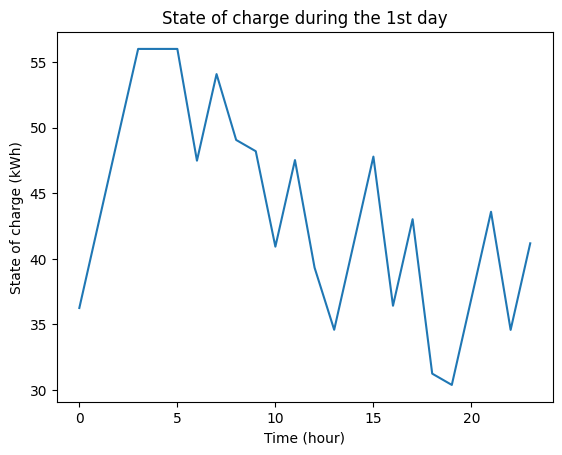

In [ ]:
# visualize an example 
plt.title("State of charge during the 1st day")
plt.xlabel('Time (hour)')
plt.ylabel('State of charge (kWh)')
plt.plot(data[0])

## Develop a prediction model that takes the last 24h of state-of-charge levels as an input and gives the prediction about the state-of-charge for the next 24 hours. (So, time series with 24 elements as an model input and the time series of 24 elements as an output). 

We are working with sequential data → best option is to use Recurrent NN.

We are creating a model that predicts new data based on previous day values.

Split data in the following way:

Train data: data of one day as X | data of the following day as Y

Test data: data of one day as X | data of the following day as Y

So, basically, state-of-charge values are used as input and labels in the same time: train_X[i] = soc[i], train_y[i] = soc[i+1]. For example, we have records for 1, 2 and 3 of March. Then, soc of the 2nd day is a label for the 1st day input, soc of the 3rd day is a label for the 2nd day input, and so on. 

Here I won't use train_test_split function, because split depends on which car data belongs to: every 30th and 31th sample belongs to different cars. I am going to split data by days: train data 1-20 days, validation data 20-25 days, test data 25-30 days.

In [ ]:
train = []
val =  []
test = []

# preprosessing data: splitting into train, val and test sets
counter = 0
for i in range(len(data)):
  counter += 1
  if 1 <= counter <= 20:
    train.append(data[i])
  elif 20 <= counter <= 25:
    val.append(data[i])
  else:
    test.append(data[i])

  if counter == 30:
    counter = 0

train = np.array(train)
val = np.array(val)
test = np.array(test)
print(train.shape, val.shape, test.shape)

(2000, 24) (500, 24) (500, 24)


Now I am going to create labels for data.

For each day labels are data from the following day.

In [ ]:
X_train = []
y_train = []
#jump_count_train = 0
for i in range(len(train)-1):
  # here we jump from one car to another
  # if don't jump, then data from other car will be labels to another car data
  if i%25==0:
    #jump_count_train += 1
    continue
  X_train.append(train[i])
  y_train.append(train[i+1])


X_val = []
y_val = []

for i in range(len(val)-1):
  if i%5==0:
    continue
  X_val.append(val[i])
  y_val.append(val[i+1])


X_test = []
y_test = []
#jump_count_test = 0
for i in range(len(test)-1):
  if i%5==0:
    #jump_count_test += 1
    continue
  X_test.append(test[i])
  y_test.append(test[i+1])

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)
#print(jump_count_train, jump_count_test) # must be 100 jumps for each split

(1919, 24) (1919, 24) (399, 24) (399, 24) (399, 24) (399, 24)


Normalize data to increase convergence rate in RNN:

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_norm = scaler.fit_transform(X_train)
y_train_norm = scaler.fit_transform(y_train)
X_val_norm = scaler.fit_transform(X_val)
y_val_norm = scaler.fit_transform(y_val)
X_test_norm = scaler.fit_transform(X_test)
y_test_norm = scaler.fit_transform(y_test)

And, finally, training the model:

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.random.set_seed(42)

inputs = layers.Input(shape=X_train[0].shape)
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(1500, return_sequences=True)(x)
x = layers.LSTM(1000, activation="relu")(x)
output = layers.Dense(24)(x)

model = tf.keras.Model(inputs=inputs, outputs=output)

# Compile model
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))

# Fit model
model.fit(X_train_norm,
          y_train_norm,
          epochs=100,
          verbose=1,
          batch_size=200,
          validation_data=(X_val_norm, y_val_norm))

Epoch 1/100
10/10 [==============================] - 9s 527ms/step - loss: 0.2706 - val_loss: 0.1446
Epoch 2/100
10/10 [==============================] - 5s 520ms/step - loss: 0.0581 - val_loss: 0.0551
Epoch 3/100
10/10 [==============================] - 5s 469ms/step - loss: 0.0344 - val_loss: 0.0381
Epoch 4/100
10/10 [==============================] - 5s 457ms/step - loss: 0.0278 - val_loss: 0.0376
Epoch 5/100
10/10 [==============================] - 5s 549ms/step - loss: 0.0254 - val_loss: 0.0363
Epoch 6/100
10/10 [==============================] - 5s 465ms/step - loss: 0.0244 - val_loss: 0.0371
Epoch 7/100
10/10 [==============================] - 5s 537ms/step - loss: 0.0241 - val_loss: 0.0359
Epoch 8/100
10/10 [==============================] - 5s 459ms/step - loss: 0.0239 - val_loss: 0.0366
Epoch 9/100
10/10 [==============================] - 5s 457ms/step - loss: 0.0239 - val_loss: 0.0358
Epoch 10/100
10/10 [==============================] - 8s 789ms/step - loss: 0.0238 - val_lo

Having a look at losses, we observe quite high difference between train and validation dataset losses. It means that the model overfits on the training data.

In [ ]:
# evaluate on test data
model.evaluate(X_test_norm, y_test_norm)
y_pred = model.predict(X_test_norm)
# we also need to revert predicted data
y_pred = scaler.inverse_transform(y_pred)

13/13 [==============================] - 1s 52ms/step


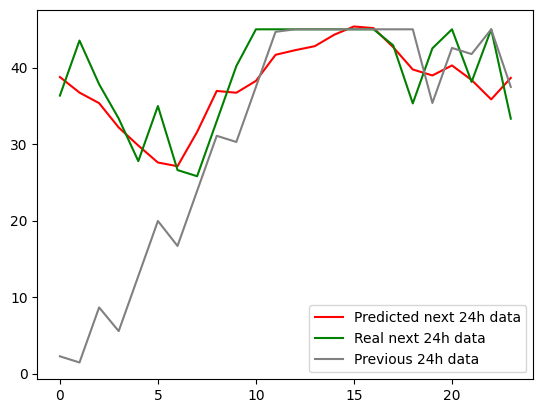

In [ ]:
# visualize one nice example
plt.plot(y_pred[5], label='Predicted next 24h data', color='red')
plt.plot(y_test[5], label='Real next 24h data', color='green')
plt.plot(X_test[5], label='Previous 24h data', color='grey')
plt.legend()

##Describe and explain the model selection (why did you use this model)? 

I decided to use Recurrent NN Long Short-Term Memory (LSTM) model, as it is such a network that is usually used to predict sequential data.

Data in the provided dataset is a sequence becase it consists of series of ordered events (series of 24 values, ordered events - 1st, 2nd, 3rd, etc. hours) - time series data.

##Envision how the results of this project could be packaged (describe the potential user or machine interface)?

This information may be useful for several categories of people/companies:

1. Owners of electronic vehicles. It may be useful to check battery charging level prediction before trips: it may make easier to plan where and when charge a vehicle.

Interface: integrate this info into car's mobile application (if there is any), or create a mobile app. One more convenient way to integrate this into vehicle's electronic board panel (integrate predictions as a vehicle's parameter that is shown on the main driver panel). 

2. Energy providers and charging station providers. Having such predictions, they know when charge demand is high. Thus, they can optimize energy supply. Also, charging stations may consider this information while planning where to place new charning stations.

Interface: Raw data that is intergrated/stored in companies' data applications/cloud services, which their data analysts can process.